In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all words
words = open('names.txt').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [4]:
len(words)

32033

In [12]:
# build vocabulary of charactars and mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [132]:
# build the datset
batch_size = 3

X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * batch_size
    for c in w + '.':
        idx = stoi[c]
        X.append(context)
        Y.append(idx)
        # print(''.join(itos[i] for i in context), '---->', c)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
        

In [29]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [53]:
C = torch.randn((27, 2))

In [55]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [56]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [73]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)


tensor([[-0.8481,  0.9984,  0.9237,  ..., -0.9521, -0.4219, -0.1763],
        [-0.6089,  0.9994,  0.9979,  ..., -0.9619,  0.2693, -0.8520],
        [-0.2949,  1.0000,  0.9840,  ..., -0.9921, -0.9050, -0.9179],
        ...,
        [ 0.8521,  0.9944, -0.7547,  ..., -1.0000, -0.2343, -0.9945],
        [ 0.4022,  0.9356, -0.7752,  ...,  0.5564,  0.8799,  0.4698],
        [ 0.8082,  0.9051,  0.9962,  ..., -0.7651,  0.9334, -0.5257]])

In [80]:
h.shape

torch.Size([32, 100])

In [76]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [78]:
logits = h @ W2 + b2

In [79]:
logits.shape

torch.Size([32, 27])

In [81]:
counts = logits.exp()

In [83]:
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[2.3012e-01, 8.5163e-11, 4.0191e-06, 3.2519e-02, 2.0536e-04, 1.3699e-03,
         5.3536e-14, 1.3027e-05, 1.8940e-06, 6.0533e-03, 3.2789e-04, 4.5125e-07,
         2.3771e-06, 8.9464e-10, 1.2299e-09, 4.5342e-06, 5.5216e-05, 6.9189e-03,
         1.2800e-04, 4.7487e-03, 3.5014e-03, 1.0790e-04, 6.4943e-09, 7.1151e-01,
         2.1315e-05, 2.3821e-03, 2.9759e-09],
        [2.2083e-01, 2.1989e-14, 1.9087e-04, 6.7965e-01, 6.7064e-08, 3.8897e-05,
         2.8001e-18, 1.8316e-09, 1.6319e-09, 1.7503e-05, 1.6328e-04, 1.1432e-08,
         6.9715e-08, 8.3400e-13, 4.0987e-10, 2.0810e-11, 7.2222e-08, 3.6971e-07,
         2.2960e-06, 1.0956e-05, 2.7130e-04, 1.4662e-09, 1.7018e-10, 9.8830e-02,
         2.5872e-07, 4.8796e-11, 9.3859e-13],
        [6.9613e-05, 1.4715e-15, 8.9132e-09, 1.3823e-05, 3.0317e-09, 3.8926e-07,
         7.9862e-17, 5.4302e-12, 1.3510e-12, 8.5486e-07, 8.6776e-08, 6.2056e-12,
         5.5811e-11, 4.1379e-19, 5.7534e-12, 2.4162e-14, 4.9995e-11, 4.5402e-06,
         1.5609e-

In [101]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(16.2675)

# Made it Respectable 

In [133]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [249]:
# init
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [250]:
sum(p.nelement() for p in parameters)

3481

In [251]:
for p in parameters:
    p.requires_grad = True

In [246]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [273]:
lri = []
lossi = []
for i in range(10000):
    # mini-batch
    batch_idxs = torch.randint(0, X.shape[0], (32, ))
    X_batch = X[batch_idxs]
    Y_batch = Y[batch_idxs]
    # forward pass
    emb = C[X_batch]
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

    
# print(loss.item())

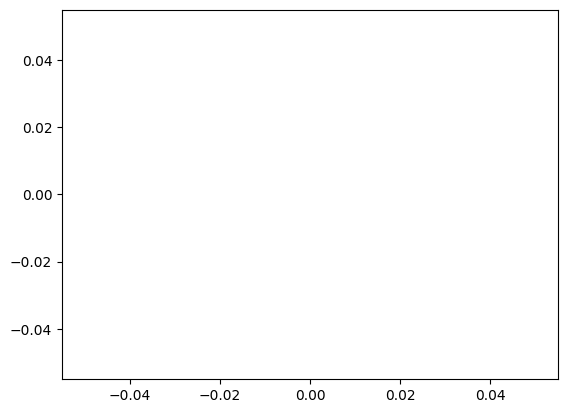

In [271]:
plt.plot(lri, lossi)

In [274]:
# loss for all datasets
emb = C[X]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2857, grad_fn=<NllLossBackward0>)